In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os, glob
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist


1. models

In [2]:
def gauss(params, stim):
    '''gauss noise'''
    sigma = params[0]
    mu = stim
    return mu, np.full_like(stim, sigma)

def gauss_bias(params, stim):
    '''gauss noise + bias'''
    sigma, bias = params
    mu = stim + bias
    return mu, np.full_like(stim, sigma)

def beta_const_noise(params, stim01, EPS=1e-9):
    """const noise, kappa"""
    (kappa,) = params
    mu = np.clip(stim01.astype(float), EPS, 1-EPS) # guards endpoints
    a  = mu * kappa
    b  = (1 - mu) * kappa
    return a, b

def beta_var_noise(params, stim01, EPS=1e-9):
    ''' stim-dependent noise (kappa)'''
    eta0, eta1 = params
    mu = np.clip(stim01.astype(float), EPS, 1-EPS)          # clip μ
    
    # kappa varies with distance from boundary (-.5 bc normed)
    kappa = softplus(eta0 + eta1 * np.abs(mu - 0.5)) + 1e-6 # κ>0
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def beta_logistic(params, stim01, EPS=1e-9):
    ''' logistic mean, const kappa '''
    # bias, slope, noise param for kappa
    w0, w1, eta = params

    # logistic
    mu = 1.0 / (1.0 + np.exp(-(w0 + w1*(stim01 - 0.5))))
    mu = np.clip(mu.astype(float), EPS, 1-EPS)
    
    # const kappa
    kappa = softplus(eta) + 1e-6
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def norm01(x, lo=-.38, hi=.38):
    '''Normalize input to [0,1] range.'''
    normed = (x - lo) / (hi - lo)
    clipped = np.clip(normed, 1e-6, 1-1e-6)
    return clipped

def inv_norm01(y, lo=-.38, hi=.38):
    """Map [0,1] back to [lo,hi]."""
    return lo + y * (hi - lo)

def softplus(z): return np.log1p(np.exp(z))


3. fitting & comparing functions

In [3]:
def gauss_ll(gauss_model, params, stim, resp):
    '''Log-likelihood for Gaussian continuous responses.'''
    mu, sigma = gauss_model(params, stim)
    
    resid = resp - mu
    ll = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (resid**2)/(sigma**2))
    return ll

def beta_ll(beta_model, params, normed_stim, resp, EPS=1e-9):
    '''Log-likelihood for Beta continuous responses.'''
    a, b = beta_model(params, normed_stim)
    resp = np.clip(resp.astype(float), EPS, 1 - EPS)  # guard endpoints
    ll = np.sum(beta_dist.logpdf(resp, a=a, b=b))
    return ll

def fit_model(model, stim, resp, init_params, bounds):
    '''Fit a model to the data by minimizing the negative log-likelihood.'''

    # choose the right likelihood function
    ll_func = beta_ll if model in beta_models else gauss_ll

    # wrapper: given parameters, compute *negative* log-likelihood
    def nll(theta):
        loglik = ll_func(model, theta, stim, resp)
        return -loglik
    
    result = minimize(nll, init_params, bounds=bounds)
    return result.x, -result.fun # params, -ll

def bic(loglik, num_params, num_trials):
    '''Bayesian Information Criterion (BIC) for model comparison.'''
    return -2*loglik + num_params * np.log(num_trials)


4. data

In [4]:
# REAL
df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
stim = df['stim_pos_aligned'].values
resp = df['chosen_pos_aligned'].values
div = df['div_pos_aligned'].values
normed_stim, normed_resp = norm01(stim), norm01(resp)

# SIMULATED
np.random.seed(0)

# gaussian
bias, noise = 0, .1
resp_gauss = normed_stim + bias + np.random.normal(0, noise, len(normed_stim))

# beta kappa
kappa = 5.0
a, b = beta_const_noise([kappa], normed_stim)
resp_beta_const_noise = np.random.beta(a,b)

# mean = stim, kappa varies with |stim-0.5|
a, b = beta_var_noise([1.0, 3.0], normed_stim)
resp_beta_var_noise = np.random.beta(a, b)

# logistic mean, constant kappa
a, b = beta_logistic([0.0, 8.0, 2.0], normed_stim)
resp_beta_logistic = np.random.beta(a, b)


5. plots

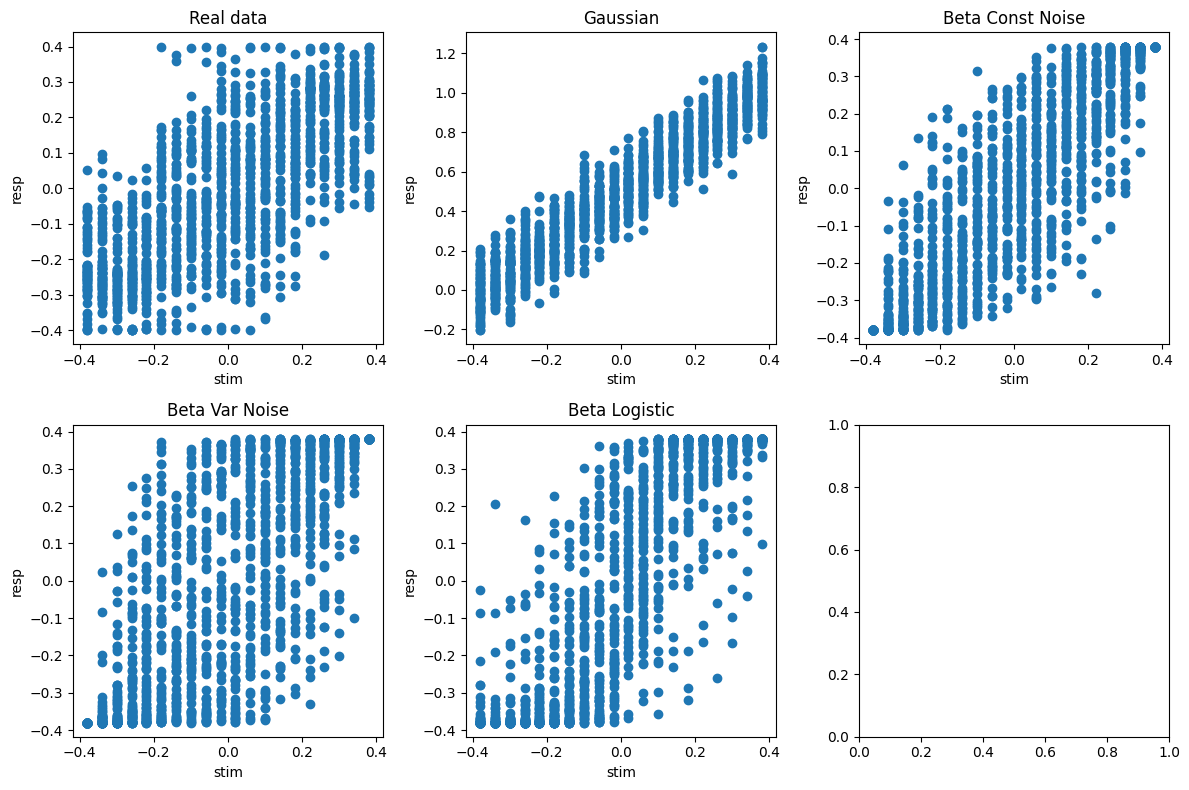

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(4*3, 4*2))
axs, ax = axs.flatten(), 0

axs[ax].scatter(stim, resp)
axs[ax].set(title='Real data', xlabel='stim', ylabel='resp')
ax += 1

axs[ax].scatter(stim, resp_gauss)
axs[ax].set(title='Gaussian', xlabel='stim', ylabel='resp')
ax += 1

axs[ax].scatter(stim, inv_norm01(resp_beta_const_noise))
axs[ax].set(title='Beta Const Noise', xlabel='stim', ylabel='resp')
ax += 1

axs[ax].scatter(stim, inv_norm01(resp_beta_var_noise))
axs[ax].set(title='Beta Var Noise', xlabel='stim', ylabel='resp')
ax += 1

axs[ax].scatter(stim, inv_norm01(resp_beta_logistic))
axs[ax].set(title='Beta Logistic', xlabel='stim', ylabel='resp')
ax += 1

plt.tight_layout()
plt.show()

6. fitting data

In [6]:
beta_models = {beta_const_noise, beta_var_noise, beta_logistic}
gauss_models = {gauss, gauss_bias}

fits = []

models = [
    ("gauss",             gauss,             [0.5],              [(1e-6, None)]),                     # sigma>0
    ("beta_const_noise",  beta_const_noise,  [5.0],              [(1e-6, None)]),                     # kappa (const noise)
    ("beta_var_noise",    beta_var_noise,    [1.0, 0.0],         [(None, None), (None, None)]),       # eta0, eta1 (base noise, stim-dependent noise)
    ("beta_logistic",     beta_logistic,     [0.0, 3.0, 1.0],    [(None,None),(None,None),(None,None)]) # w0,w1,eta (bias, slope, const noise)
]

for name, fn, init, bounds in models:
    params, ll = fit_model(fn, normed_stim, normed_resp, init_params=init, bounds=bounds)
    fits.append({"model": name, "params": params, "LL": ll, "BIC": bic(ll, len(params), len(normed_stim))})

fits_sorted = sorted(fits, key=lambda x: x["BIC"])
fits_sorted


[{'model': 'beta_logistic',
  'params': array([-0.04532754,  2.93414477,  2.37503349]),
  'LL': np.float64(448.9263781283288),
  'BIC': np.float64(-876.0355610789475)},
 {'model': 'gauss',
  'params': array([0.20989787]),
  'LL': np.float64(204.76171519627692),
  'BIC': np.float64(-402.2510319999838)},
 {'model': 'beta_var_noise',
  'params': array([1.209094  , 6.88025472]),
  'LL': np.float64(-1329.8215551352846),
  'BIC': np.float64(2674.1879070557093)},
 {'model': 'beta_const_noise',
  'params': array([2.85002276]),
  'LL': np.float64(-1395.7623888463977),
  'BIC': np.float64(2798.7971760853657)}]